# Qual é o melhor plano?

A empresa, Megaline telecomunicações, oferece aos clientes dois planos pré-pagos: Surf e Ultimate. O departamento comercial quer saber qual dos planos gera mais receita para ajustar o orçamento de publicidade.

Eu irei realizar uma análise preliminar dos planos com base em uma pequena seleção de clientes. Eu terei dados de 500 clientes da Megaline: que clientes são, de onde eles são, qual plano usam e o número de chamadas e mensagens realizadas em 2018. Meu trabalhos será analisar o comportamento dos clientes e determinar qual plano pré-pago gera mais receita.

## DESCRIÇÃO DOS PLANOS:

**Observação**: A Megaline arredonda segundos para minutos e megabytes para gigabytes. Para chamadas, cada chamada individual é arredondada para cima: mesmo que uma chamada tenha durado apenas um segundo, um minuto será contado. Para tráfego da web, sessões individuais da web não são arredondadas para cima. Ao invés disso, o total do mês é arredondado para cima. Se alguém usar 1.025 megabytes no mês, a cobrança será de 2 gigabytes.


- Plano `surf`:
    - `Preço Mensal`: $20
    - 500 minutos mensais, 50 mensagens de texto e 15 GB de dados
    - Após exceder os limites do pacote:
        - 1 minuto: 3 centavos
        - 1 mensagem de texto: 3 centavos
        - 1 GB de dados: $10

- Plano `Ultimate`:
    - `Preço Mensal`: $70
    - 3.000 minutos mensais, 1.000 mensagens de texto e 30 GB de dados
    - Após exceder os limites do pacote:
        - 1 minuto: 1 centavo
        - 1 mensagem de texto: 1 centavos
        - 1 GB de dados: $7


## Dicionário de dados

Há cinco tabelas no conjunto de dados, abaixo está um dicionário que lista as colunas de cada tabela e descreve os dados contidos nelas.

- A Tabela `users`:
    - `'user_id'`: identificação do usuário
    - `'first_name'`: nome do usuário
    - `'last_name'`: sobrenome do usuário
    - `'age'`: idade do usuário (em anos)
    - `'reg_date'`: data da inscrição (dd, mm, aa)
    - `'churn_date'`: a data que o usuário parou de usar o serviço (se o valor estiver ausente, isso significa que o plano estava em uso quando o banco de dados foi extraído)
    - `'city'`: cidade de residência do usuário
    - `'plan'`: nome do plano

- A Tabela `calls`:
    - `'id'`: identificação de chamada unívoco
    - `'call_date'`: data da chamada
    - `'duration'`: duração da chamada (em minutos)
    - `'user_id'`: identificação do usuário que faz a chamada

- A Tabela `messages`:
    - `'id'`: identificador unívoco da mensagem de texto
    - `'message_date'`: data da mensagem de texto
    - `'user_id'`: identificador do usuário que envia a mensagem de texto

- A Tabela `Internet`(dados sobre sessões web):
    - `'id'`: identificador unívoco da sessão
    - `'mb_used'`: volume de dados gasto durante a sessão (em megabytes)
    - `'session_date'`: data da sessão web
    - `'user_id'`: identificação do usuário

- A Tabela `plans`:
    - `'plan_name'`: nome do plano de chamadas
    - `'usd_monthly_fee'`: preço mensal em dólares americanos
    - `'minutes_included'`: pacote mensal de minutos
    - `'messages_included'`: pacote mensal de mensagens de texto
    - `'mb_per_month_included'`: volume do pacote de dados (em megabytes)
    - `'usd_per_minute'`: preço por minuto depois de exceder o limite do pacote (por exemplo, se o pacote inclui 100 minutos, o primeiro minuto excedente será cobrado)
    - `'usd_per_message'`: preço por mensagem de texto depois de exceder o limite do pacote
    - `'usd_per_gb'`: preço por gigabyte extra de dados após exceder o limite do pacote (1 GB = 1.024 megabytes)


# Plano para o Projeto

Durante a realização deste projeto, irei manipular os dados para verificar se há problemas com os mesmos e logo em seguida fazer comparações, agregações e análises ricas em dados para entregar ao departamento comercial tomar suas decisões estratégicas.

## Inicialização: carregando as principais `Bibliotecas` que serão usadas.

In [40]:
import pandas as pd
from scipy import stats as st
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt

## Carreguando os dados:

In [41]:
df_msg = pd.read_csv('megaline_messages.csv')
df_users = pd.read_csv('megaline_users.csv')
df_calls = pd.read_csv('megaline_calls.csv')
df_plans = pd.read_csv('megaline_plans.csv')
df_int = pd.read_csv('megaline_internet.csv')


## Preparando os dados:

## Planos

In [42]:
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [43]:
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


<span style="color:green;">O que pode-se notar é que os dados precisam ser corrigidos.</span>

## Corrigindo os dados:

**Convertando a coluna `mb_per_month_included` para GigaByte:**

In [44]:
df_plans['mb_per_month_included'] = df_plans['mb_per_month_included'] / 1024
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


**Arrendondando `mb_per_month_included` para baixo para que os dados fiquem de acordo com que os planos oferecem:**

In [45]:
df_plans['mb_per_month_included'] = np.floor(df_plans['mb_per_month_included']).astype('int')
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


**Mudando o nome da coluna `mb_per_month_included` para `gb_per_month_included`:**

In [46]:
df_plans = df_plans.rename(columns={'mb_per_month_included': 'gb_per_month_included'})
df_plans.head()

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Usuários

In [47]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [48]:
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


<span style="color:green;">O que pode-se notar é que os dados precisam ser corrigidos na coluna `'churn_date'`.</span>

### Corrigindo os dados:

In [49]:
df_users['churn_date'].fillna('Client', inplace=True)
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Client
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Client
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,Client
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,Client
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,Client


### Enriquecendo os dados:

**Mudando o nome da coluna `plan` para `plan_name` já pensando futuramente numa junção desses dataframes:**

In [50]:
df_users = df_users.rename(columns={'plan': 'plan_name'})
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan_name,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Client
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Client
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,Client
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,Client
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,Client


## Chamadas

In [51]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [52]:
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


<span style="color:green;">O que pode-se notar é que os dados precisam ser corrigidos na coluna `'duration'`.</span>

### Corrigindo os dados:

**Realizando o arredondamento dos valores da coluna `duration`:**

In [53]:
df_calls['duration'] = df_calls['duration'].round(0).astype('int')
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,14
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,4


### Enriquecendo os dados:

**Utilizando métodos para separar o mês da data principal para futuras análises:**

In [54]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls['mes'] = df_calls['call_date'].dt.month
df_calls

,id,user_id,call_date,duration,mes
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,14,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,4,12
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,9,11
137731,1499_200,1499,2018-10-20,11,10
137732,1499_201,1499,2018-09-21,8,9
137733,1499_202,1499,2018-10-10,0,10


## Mensagens

In [55]:
df_msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [56]:
df_msg.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


<span style="color:green;">Sem correções para fazer.</span>

### Enriquecendo os dados:

**Utilizando métodos para separar o mês da data principal para futuras análises:**

In [57]:
df_msg['message_date'] = pd.to_datetime(df_msg['message_date'])
df_msg['mes'] = df_msg['message_date'].dt.month
print(df_msg)

             id  user_id message_date  mes
0      1000_125     1000   2018-12-27   12
1      1000_160     1000   2018-12-31   12
2      1000_223     1000   2018-12-31   12
3      1000_251     1000   2018-12-27   12
4      1000_255     1000   2018-12-26   12
...         ...      ...          ...  ...
76046  1497_526     1497   2018-12-24   12
76047  1497_536     1497   2018-12-24   12
76048  1497_547     1497   2018-12-31   12
76049  1497_558     1497   2018-12-24   12
76050  1497_613     1497   2018-12-23   12

[76051 rows x 4 columns]


## Internet

In [58]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [59]:
df_int.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


<span style="color:green;">O que pode-se notar é que os dados precisam ser corrigidos na coluna `'mb_used'`.</span>

### Corrigindo os dados:

**Transformando os valores para GigaByte:**

In [60]:
df_int['mb_used'] = (df_int['mb_used']/1024)
df_int.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,0.087754
1,1000_204,1000,2018-12-31,0.000000
2,1000_379,1000,2018-12-28,0.644922
3,1000_413,1000,2018-12-26,0.264639
4,1000_442,1000,2018-12-27,0.859590


In [61]:
df_int['mb_used'] = df_int['mb_used'].apply(math.ceil)
df_int.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,1
1,1000_204,1000,2018-12-31,0
2,1000_379,1000,2018-12-28,1
3,1000_413,1000,2018-12-26,1
4,1000_442,1000,2018-12-27,1


**Mudando o nome da coluna `mb_used` para `gb_used`:**

In [62]:
df_int = df_int.rename(columns={'mb_used': 'gb_used'})
df_int.head()

,id,user_id,session_date,gb_used
0,1000_13,1000,2018-12-29,1
1,1000_204,1000,2018-12-31,0
2,1000_379,1000,2018-12-28,1
3,1000_413,1000,2018-12-26,1
4,1000_442,1000,2018-12-27,1


### Enriquecendo os dados:

**Utilizando métodos para separar o mês da data principal para futuras análises:**

In [63]:
df_int['session_date'] = pd.to_datetime(df_int['session_date'])
df_int['mes'] = df_int['session_date'].dt.month
print(df_int.head())

         id  user_id session_date  gb_used  mes
0   1000_13     1000   2018-12-29        1   12
1  1000_204     1000   2018-12-31        0   12
2  1000_379     1000   2018-12-28        1   12
3  1000_413     1000   2018-12-26        1   12
4  1000_442     1000   2018-12-27        1   12


## Estudando as condições dos planos:

In [64]:
df_plans.head()

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Agregando os dados por usuário:

In [65]:
df_calls.head()

,id,user_id,call_date,duration,mes
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,14,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,4,12


**Calculando o número de chamadas feitas por cada usuário por mês:**

In [66]:
n_calls_users = df_calls.groupby(['user_id', 'mes'])['id'].count().reset_index()
n_calls_users

,user_id,mes,id
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


**Calculando a quantidade de minutos gastos por cada usuário por mês:**

In [67]:
n_min_users = df_calls.groupby(['user_id', 'mes'])['duration'].sum().reset_index()
n_min_users

,user_id,mes,duration
0,1000,12,117
1,1001,8,173
2,1001,9,297
3,1001,10,374
4,1001,11,404
...,...,...,...
2253,1498,12,326
2254,1499,9,328
2255,1499,10,361
2256,1499,11,287


In [68]:
df_msg.head()

,id,user_id,message_date,mes
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


**Calculando o número de mensagens enviadas por cada usuário por mês:**

In [69]:
n_msg_users = df_msg.groupby(['user_id', 'mes'])['id'].count().reset_index()
n_msg_users

,user_id,mes,id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [70]:
df_int.head()

,id,user_id,session_date,gb_used,mes
0,1000_13,1000,2018-12-29,1,12
1,1000_204,1000,2018-12-31,0,12
2,1000_379,1000,2018-12-28,1,12
3,1000_413,1000,2018-12-26,1,12
4,1000_442,1000,2018-12-27,1,12


**Calculando o volume de tráfego de internet usado por cada usuário por mês:**

In [102]:
internet_users = df_int.groupby(['user_id', 'mes'])['gb_used'].sum().reset_index()
internet_users

,user_id,mes,gb_used
0,1000,12,4
1,1001,8,21
2,1001,9,41
3,1001,10,50
4,1001,11,49
...,...,...,...
2272,1498,12,56
2273,1499,9,37
2274,1499,10,52
2275,1499,11,43


**Realizando o `Merge()` de dataframes que possuem colunas em comum para análise dos dados:**

In [72]:
new_merge_1 = pd.merge(n_calls_users, n_min_users, on=['user_id', 'mes'], how='outer')
new_merge_2 = pd.merge(new_merge_1, n_msg_users, on=['user_id', 'mes'], how='outer')
new_merge_3 = pd.merge(new_merge_2, internet_users, on=['user_id', 'mes'], how='outer').reset_index()
new_merge_3 = new_merge_3.rename(columns={'id_x': 'n_calls', 'duration': 'n_min', 'id_y': 'n_msgs'})
new_merge_3

,index,user_id,mes,n_calls,n_min,n_msgs,gb_used
0,0,1000,12,16.0,117.0,11.0,4.0
1,1,1001,8,27.0,173.0,30.0,21.0
2,2,1001,9,49.0,297.0,44.0,41.0
3,3,1001,10,65.0,374.0,53.0,50.0
4,4,1001,11,64.0,404.0,36.0,49.0
...,...,...,...,...,...,...,...
2288,2288,1349,12,NaN,NaN,61.0,27.0
2289,2289,1361,5,NaN,NaN,2.0,7.0
2290,2290,1482,10,NaN,NaN,2.0,NaN
2291,2291,1108,12,NaN,NaN,NaN,2.0


**Realizando o `Merge()` dos dataframes faltantes `df_plans` e `df_users` através das colunas que os conectam:**

In [73]:
df_merged_plans = pd.merge(df_plans, df_users[['plan_name', 'user_id']], on='plan_name', how='outer')
df_merged_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,user_id
0,50,15,500,20,10,0.03,0.03,surf,1001
1,50,15,500,20,10,0.03,0.03,surf,1002
2,50,15,500,20,10,0.03,0.03,surf,1003
3,50,15,500,20,10,0.03,0.03,surf,1004
4,50,15,500,20,10,0.03,0.03,surf,1005
...,...,...,...,...,...,...,...,...,...
495,1000,30,3000,70,7,0.01,0.01,ultimate,1482
496,1000,30,3000,70,7,0.01,0.01,ultimate,1487
497,1000,30,3000,70,7,0.01,0.01,ultimate,1490
498,1000,30,3000,70,7,0.01,0.01,ultimate,1493


**Finalmente realizando o `Merge()` de todos os dataframes para uma análise mais profunda dos dados:**

In [74]:
df_merged_all = pd.merge(new_merge_3, df_merged_plans, on='user_id', how='outer')
df_merged_all

,index,user_id,mes,n_calls,n_min,n_msgs,gb_used,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,0.0,1000,12.0,16.0,117.0,11.0,4.0,1000,30,3000,70,7,0.01,0.01,ultimate
1,1.0,1001,8.0,27.0,173.0,30.0,21.0,50,15,500,20,10,0.03,0.03,surf
2,2.0,1001,9.0,49.0,297.0,44.0,41.0,50,15,500,20,10,0.03,0.03,surf
3,3.0,1001,10.0,65.0,374.0,53.0,50.0,50,15,500,20,10,0.03,0.03,surf
4,4.0,1001,11.0,64.0,404.0,36.0,49.0,50,15,500,20,10,0.03,0.03,surf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,NaN,1473,NaN,NaN,NaN,NaN,NaN,50,15,500,20,10,0.03,0.03,surf
2299,NaN,1025,NaN,NaN,NaN,NaN,NaN,1000,30,3000,70,7,0.01,0.01,ultimate
2300,NaN,1269,NaN,NaN,NaN,NaN,NaN,1000,30,3000,70,7,0.01,0.01,ultimate
2301,NaN,1275,NaN,NaN,NaN,NaN,NaN,1000,30,3000,70,7,0.01,0.01,ultimate


**Calculando a receita mensal para cada usuário:**

In [75]:
def revenue_calc(row):
    user_plan = df_merged_all[df_merged_all['plan_name'] == row['plan_name']].iloc[0]
    
    revenue = user_plan['usd_monthly_pay']
    if row['n_min'] > user_plan['minutes_included']:
        revenue += (row['n_min'] - user_plan['minutes_included']) * user_plan['usd_per_minute']
    if row['n_msgs'] > user_plan['messages_included']:
        revenue += (row['n_msgs'] - user_plan['messages_included']) * user_plan['usd_per_message']
    if row['gb_used'] > user_plan['usd_per_gb']:
        revenue += (row['gb_used'] - user_plan['usd_per_gb']) * user_plan['usd_per_gb']
        

    return revenue

In [103]:
df_merged_all['revenue'] = df_merged_all.apply(revenue_calc, axis = 1)
df_merged_all

,index,user_id,mes,n_calls,n_min,n_msgs,gb_used,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,revenue
0,0.0,1000,12.0,16.0,117.0,11.0,4.0,1000,30,3000,70,7,0.01,0.01,ultimate,70.00
1,1.0,1001,8.0,27.0,173.0,30.0,21.0,50,15,500,20,10,0.03,0.03,surf,130.00
2,2.0,1001,9.0,49.0,297.0,44.0,41.0,50,15,500,20,10,0.03,0.03,surf,330.00
3,3.0,1001,10.0,65.0,374.0,53.0,50.0,50,15,500,20,10,0.03,0.03,surf,420.09
4,4.0,1001,11.0,64.0,404.0,36.0,49.0,50,15,500,20,10,0.03,0.03,surf,410.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,NaN,1473,NaN,NaN,NaN,NaN,NaN,50,15,500,20,10,0.03,0.03,surf,20.00
2299,NaN,1025,NaN,NaN,NaN,NaN,NaN,1000,30,3000,70,7,0.01,0.01,ultimate,70.00
2300,NaN,1269,NaN,NaN,NaN,NaN,NaN,1000,30,3000,70,7,0.01,0.01,ultimate,70.00
2301,NaN,1275,NaN,NaN,NaN,NaN,NaN,1000,30,3000,70,7,0.01,0.01,ultimate,70.00


## Estudando o comportamento do usuário:

### Chamadas

**Agregando dados para mostrar a média de minutos utilizados cada mês por plano:**

In [77]:
df_min_avg = df_merged_all.groupby(['plan_name', 'mes'])['n_min'].mean().reset_index()
df_min_avg

,plan_name,mes,n_min
0,surf,1.0,193.000000
1,surf,2.0,281.111111
2,surf,3.0,311.000000
3,surf,4.0,332.460000
4,surf,5.0,386.866667
5,surf,6.0,410.937500
6,surf,7.0,427.850000
7,surf,8.0,394.371069
8,surf,9.0,397.047120
9,surf,10.0,414.560345


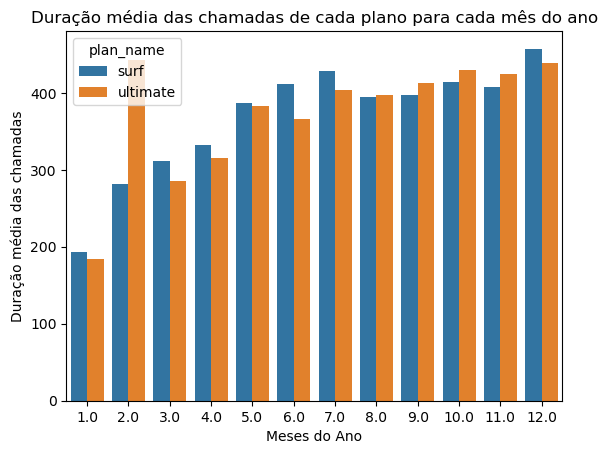

In [105]:
sns.barplot(data=df_min_avg, x='mes', y='n_min', hue='plan_name')
plt.title('Duração média das chamadas de cada plano para cada mês do ano')
plt.xlabel('Meses do Ano')
plt.ylabel('Duração média das chamadas');

<span style="color:green;">Como pode-se ver acima, as médias do número de minutos utilizados são bem parecidas de março a dezembro, porém no mês de janeiro os usuários do Plano Surf usaram 1/3 a mais do que os usuários do Plano Ultimate e no mês de fevereiro foi ao contrário.</span>

**Agregando dados para mostrar a soma de minutos utilizados cada mês por plano e por usuário:**

In [79]:
df_min_necs = df_merged_all.groupby(['plan_name', 'mes', 'user_id'])['n_min'].sum().reset_index()
df_min_necs

,plan_name,mes,user_id,n_min
0,surf,1.0,1042,107.0
1,surf,1.0,1362,279.0
2,surf,2.0,1042,242.0
3,surf,2.0,1099,37.0
4,surf,2.0,1138,286.0
...,...,...,...,...
2288,ultimate,12.0,1482,53.0
2289,ultimate,12.0,1487,396.0
2290,ultimate,12.0,1490,348.0
2291,ultimate,12.0,1493,450.0


c:\Users\mkzin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


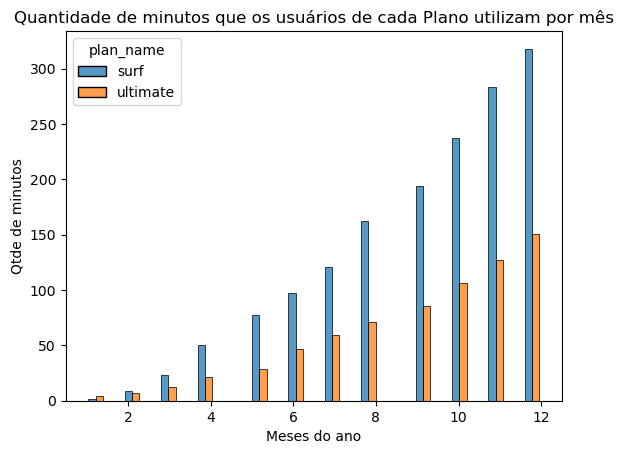

In [123]:
sns.histplot(data=df_min_necs, x="mes", hue="plan_name", multiple="dodge", shrink=.8)
plt.title('Quantidade de minutos que os usuários de cada Plano utilizam por mês')
plt.xlabel('Meses do ano')
plt.ylabel('Qtde de minutos');

<span style="color:green;">Como pode-se notar acima, os usuários do Plano Surf somados utilizam o dobro de minutos em ligações em relação aos usuários do Plano Ultimate, isso se dá também porque há o dobro de usuários que assinaram o Plano Surf.</span>

**Calculando a média da duração mensal das chamadas:**

In [112]:
print("A média da duração mensal das chamadas é:", df_min_necs['n_min'].mean())

A média da duração mensal das chamadas é: 405.10466637592674


**Calculando a variação da duração mensal das chamadas:**

In [111]:
variance = np.var(df_min_user_sum['n_min'])
print("A variação da duração mensal das chamadas é:", variance)

A variação da duração mensal das chamadas é: 49828.086733567354


**Exibindo um diagrama de caixa:**

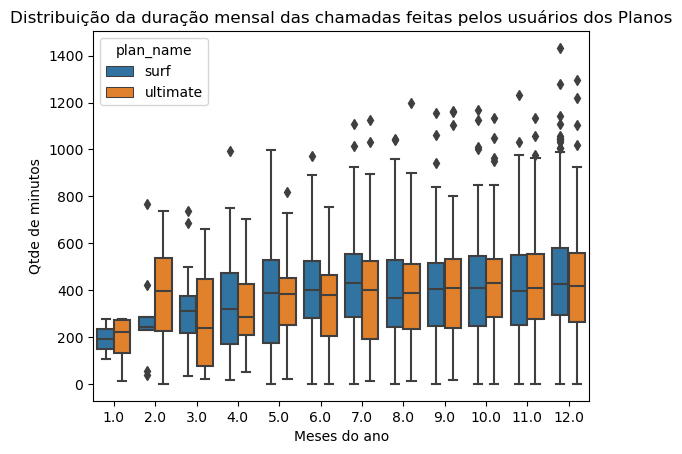

In [117]:
sns.boxplot(data=df_min_user_sum, x='mes', y='n_min', hue="plan_name")
plt.title('Distribuição da duração mensal das chamadas feitas pelos usuários dos Planos')
plt.xlabel('Meses do ano')
plt.ylabel('Qtde de minutos');

<span style="color:green;">Os comportamentos dos usuários são diferentes. Podemos notar que nos primeiros meses, os usuários do plano surf e ultimate se diferenciaram no uso dos planos com dados variando entre assimétrico a esqueda e direita, mas sem um padrão definido. E, também, podemos notar nos primeiros meses uma grande diferença no uso dos planos, sendo que os dados se encontram mais variáveis e mais dispersos no plano SURF do que no Ultimate que está mais concentrado, mas como falei anteriormente, sem muito padrão, podendo variar de um mês para o outro.</span>

<span style="color:green;">A partir do mês 7, podemos notar muitos valores atípicos nos dois planos, que podem ser usuários que usam os minutos de ligação muito mais que os outros usuários comuns. Porém, a partir do mês 7, conseguimos notar algum padrão no uso de minutos de ligação entre os dois planos, com uma leve assimetria para direita e esquerda em alguns meses, mas com um conjunto maior de dados também.</span>

### Mensagens

In [85]:
df_merged_all.head()

,index,user_id,mes,n_calls,n_min,n_msgs,gb_used,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,revenue
0,0.0,1000,12.0,16.0,117.0,11.0,4.0,1000,30,3000,70,7,0.01,0.01,ultimate,70.00
1,1.0,1001,8.0,27.0,173.0,30.0,21.0,50,15,500,20,10,0.03,0.03,surf,130.00
2,2.0,1001,9.0,49.0,297.0,44.0,41.0,50,15,500,20,10,0.03,0.03,surf,330.00
3,3.0,1001,10.0,65.0,374.0,53.0,50.0,50,15,500,20,10,0.03,0.03,surf,420.09
4,4.0,1001,11.0,64.0,404.0,36.0,49.0,50,15,500,20,10,0.03,0.03,surf,410.00


**Agregando dados para demonstrar o número de mensagens que os usuários de cada plano tendem a enviar a cada mês:**

In [86]:
group_msgs = df_merged_all.groupby(['plan_name', 'mes'])['n_msgs'].mean().reset_index()
group_msgs.head()

,plan_name,mes,n_msgs
0,surf,1.0,21.000000
1,surf,2.0,21.600000
2,surf,3.0,21.937500
3,surf,4.0,24.166667
4,surf,5.0,33.017857


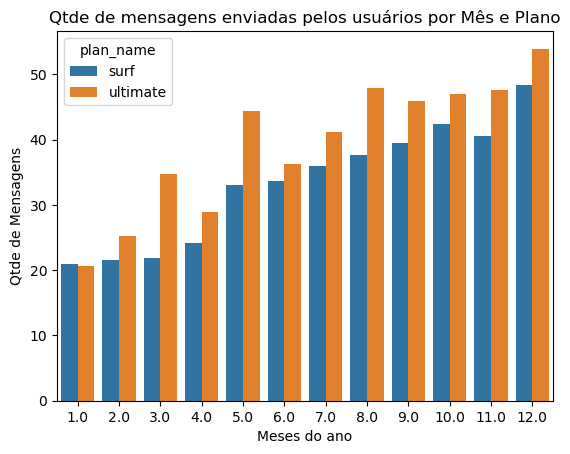

In [116]:
sns.barplot(data=group_msgs, x='mes', y='n_msgs', hue='plan_name')
plt.title('Qtde de mensagens enviadas pelos usuários por Mês e Plano')
plt.xlabel('Meses do ano')
plt.ylabel('Qtde de Mensagens');

<span style="color:green;">O que pôde-se notar nessa comparação feita é que os usuários do plano Ultimate enviam mais mensagens que do plano Surf durante todo o ano com exceção do mês de Janeiro que está bem parelho. Entretanto, isso tem uma explicação, uma vez que usuários do Plano Ultimate possuem 1000 mensagens inclusas no pacote e, por isso, eles enviam mais mensagens que os usuários do Plano Surf que possuem somente 50 mensagens durante o mês.</span>

### Internet

**Comparando a quantidade de tráfego de internet consumido pelos usuários por plano e mês**

In [89]:
group_int = df_merged_all.groupby(['plan_name', 'mes'])['gb_used'].sum().reset_index()
group_int.head(24)

,plan_name,mes,gb_used
0,surf,1.0,28.0
1,surf,2.0,270.0
2,surf,3.0,719.0
3,surf,4.0,1444.0
4,surf,5.0,2606.0
5,surf,6.0,3639.0
6,surf,7.0,4872.0
7,surf,8.0,6525.0
8,surf,9.0,7803.0
9,surf,10.0,9951.0


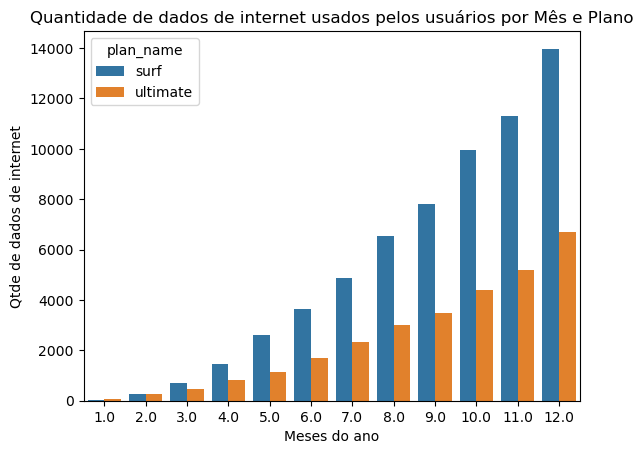

In [119]:
sns.barplot(data=group_int, x='mes', y='gb_used', hue='plan_name')
plt.title('Quantidade de dados de internet usados pelos usuários por Mês e Plano')
plt.xlabel('Meses do ano')
plt.ylabel('Qtde de dados de internet');

**Contando o número de usuários por plano:**

In [91]:
n_users_plan = df_merged_all.groupby('plan_name')['user_id'].count()
n_users_plan

plan_name
surf        1579
ultimate     724
Name: user_id, dtype: int64

<span style="color:green;">O que podemos notar neste gráfico acima é que os usuários do Plano Surf a partir do mês 4 utilizam quase ou mais que o dobro do uso de dados de intenet em relação aos usuários do Plano Ultimate. Para ajudar na análise, os usuários do Plano Ultimate possuem incluso no seu plano 30GB e os usuários do Plano Surf 15GB. Porém, analisando o gráfico podemos notar que a diferença é muito grande e se deve ao fato de que o Plano Surf tem mais que o dobro de usuários do Plano Ultimate, fazendo assim com que eleve a "soma do uso de internet" para outro nível. E, outro fator que podemos considerar é o foto de que na atualidade muitos usuários de planos de telefonia usam bastante a internet, uma vez que tudo hoje, praticamente, funciona por meio da internet.</span>

## Receita

**Agregando valores para demonstrar a soma da receita por plano e mês:**

In [92]:
group_rev = df_merged_all.groupby(['plan_name', 'mes'])['revenue'].sum().reset_index()
group_rev.head(24)

,plan_name,mes,revenue
0,surf,1.0,150.00
1,surf,2.0,2078.31
2,surf,3.0,5643.20
3,surf,4.0,10972.81
4,surf,5.0,20566.68
5,surf,6.0,29265.75
6,surf,7.0,39858.39
7,surf,8.0,53339.37
8,surf,9.0,63260.74
9,surf,10.0,81746.69


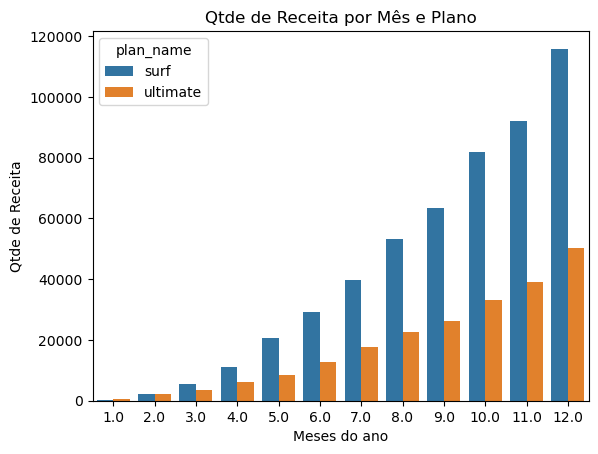

In [120]:
sns.barplot(data=group_rev, x='mes', y='revenue', hue='plan_name')
plt.title('Qtde de Receita por Mês e Plano')
plt.xlabel('Meses do ano')
plt.ylabel('Qtde de Receita');

<span style="color:green;">Como era de ser esperar, a receita do Plano Surf é muito superior, uma vez que além de mais usuários que aderiram ao plano, nós podemos observar no último gráfico o alto volume de uso de internet que excedia o que estava incluso no plano, fazendo com que a receita aumentasse muito através do plano surf, porque os usuários usaram muito dados de internet durante o ano. Lembrando que o Plano Surf tinha incluso 15 GB de dados e 1GB de dados usado além do que estava incluso possui o custo de 10 dólares neste plano. Já o Plano Ultimate tem incluso 30GB de dados e e a cada 1GB de dados usados além do que estava incluso possuia o custo de 7 dólares. Isso resume porque o Plano Surf atingiu uma grande receita, e é certamente devido ao uso massivo de dados de internet além do que está incluso no pacote.</span>

## Teste hipóteses estatísticas

**Formulando as `Hipóteses`:**

`Hipótese Nula`: as receitas médias dos usuários dos planos de chamadas Ultimate e Surf `"NÃO"` são diferentes

`Hipótese Alternativa`: as receitas médias dos usuários dos planos de chamadas Ultimate e Surf são diferentes

**Separando receitas de ambos os planos em novas variáveis:**

In [94]:
surf_revenue = df_merged_all.loc[df_merged_all['plan_name'] == "surf", 'revenue']
ultimate_revenue = df_merged_all.loc[df_merged_all['plan_name'] == "ultimate", 'revenue']

**Calculando a variância de ambos os planos:**

In [95]:
surf_revenue.var(), ultimate_revenue.var()

(29415.607367156797, 13272.964818168624)

**Aplicando o teste de Hipótese através do Python:**

In [122]:
alpha = 0.05
results = st.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)
print('valor-p: ', results.pvalue)
if (results.pvalue < alpha):
    print('Rejeitamos a hipóstese nula')
else:
    print('Não Rejeitamos a hipóstese nula')

valor-p:  0.002934369901819721
Rejeitamos a hipóstese nula


<span style="color:green;">Nós iremos rejeitar a hipótese nula, uma vez que as receitas médias dos usuários dos planos são diferentes.</span>

**Formulando novas `Hipóteses`:**

`Hipótese Nula`: a receita média dos usuários da área de NY-NJ `'NÃO'` difere dos usuários das demais regiões

`Hipótese Alternativa`: as receitas médias dos usuários dos planos de chamadas Ultimate e Surf são diferentes.

**Realizando o `merge()` nos dataframes para obter dados sobre regiões:**

In [97]:
everyt_merdged = pd.merge(df_users, df_merged_all, on=['user_id', 'plan_name'])
everyt_merdged

,user_id,first_name,last_name,age,city,reg_date,plan_name,churn_date,index,mes,...,n_msgs,gb_used,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,revenue
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Client,0.0,12.0,...,11.0,4.0,1000,30,3000,70,7,0.01,0.01,70.00
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Client,1.0,8.0,...,30.0,21.0,50,15,500,20,10,0.03,0.03,130.00
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Client,2.0,9.0,...,44.0,41.0,50,15,500,20,10,0.03,0.03,330.00
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Client,3.0,10.0,...,53.0,50.0,50,15,500,20,10,0.03,0.03,420.09
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Client,4.0,11.0,...,36.0,49.0,50,15,500,20,10,0.03,0.03,410.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,Client,2253.0,12.0,...,NaN,56.0,50,15,500,20,10,0.03,0.03,480.00
2299,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,Client,2254.0,9.0,...,NaN,37.0,50,15,500,20,10,0.03,0.03,290.00
2300,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,Client,2255.0,10.0,...,NaN,52.0,50,15,500,20,10,0.03,0.03,440.00
2301,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,Client,2256.0,11.0,...,NaN,43.0,50,15,500,20,10,0.03,0.03,350.00


**Separando em novas variáveis as receitas médias dos usuários por região:**

In [98]:
revenue_nynj = everyt_merdged[everyt_merdged['city'].str.contains('NY-NJ')]['revenue']
revenue_others = everyt_merdged[~everyt_merdged['city'].str.contains('NY-NJ')]['revenue']
print(revenue_nynj)
print()
print(revenue_others)

56       20.00
57      106.86
75       40.00
76      570.00
77      250.00
         ...  
2294    460.00
2295    440.00
2296    450.00
2297    390.00
2298    480.00
Name: revenue, Length: 378, dtype: float64

0        70.00
1       130.00
2       330.00
3       420.09
4       410.00
         ...  
2287    217.00
2299    290.00
2300    440.00
2301    350.00
2302    500.00
Name: revenue, Length: 1925, dtype: float64


**Calculando a variância da região `NY-NJ` e das `demais regiões`:**

In [99]:
revenue_nynj.var(), revenue_others.var()

(21790.203468030802, 24914.20942012619)

**Aplicando o teste de Hipótese através do Python:**

In [100]:
alpha = 0.05
results = st.ttest_ind(revenue_nynj, revenue_others)
print('valor-p: ', results.pvalue)
if (results.pvalue < alpha):
    print('Rejeitamos a hipóstese nula')
else:
    print('Não Rejeitamos a hipóstese nula')

valor-p:  0.29228971381004626
Não Rejeitamos a hipóstese nula


<span style="color:green;">Não iremos rejeitar a hipótese nula, uma vez que as receitas médias dos usuários das duas regiões não tem uma diferença relevante.</span>

## Conclusão geral

    - Foi realizada importante manipulação, correção e enriquecimento de dados durante o projeto e foram importantes para o resultado final, uma vez que as análises precisavam de dados corretos.
    - Pode-se verificar que as médias do número de minutos utilizados pelos usuários de ambos os planos foram bem parecidas durantes os meses do ano, só se diferenciando em Janeiro e Fevereiro.
    - Como há o dobro de usuários do Plano Surf em relação ao Plano Ultimate, muitas das estatísicas e cálculos aqui apresentadas mostram que o primeiro plano tem ampla vantagem no consumo de internet, ligações e, consequentemente, gera mais receita que o segundo plano. 
    - Os usuários do Plano Ultimate utilizam mais mensagens que os usuários do Plano Surf devido ao foto que os usuários do primeiro plano possuiam uma quantidade massiva de mensagens para serem usadas em comparação aos usuários do segundo plano.
    - Por fim, conseguimos concluir que as receitas médias dos usuários de ambos os planos são diferentes, mas quando comparamos os usuários da região 'NY-NJ' com as demais regiões não há uma diferença relevante.